# Bayesian Modelling

## Bayesian probability

### Example: estimating the probability of heads in a coin toss experiment

In [36]:
# Generate a sequence of binary random variables
from scipy.stats import bernoulli, beta, uniform
p = 0.3
r = bernoulli.rvs(p, size=400)
r[:10]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

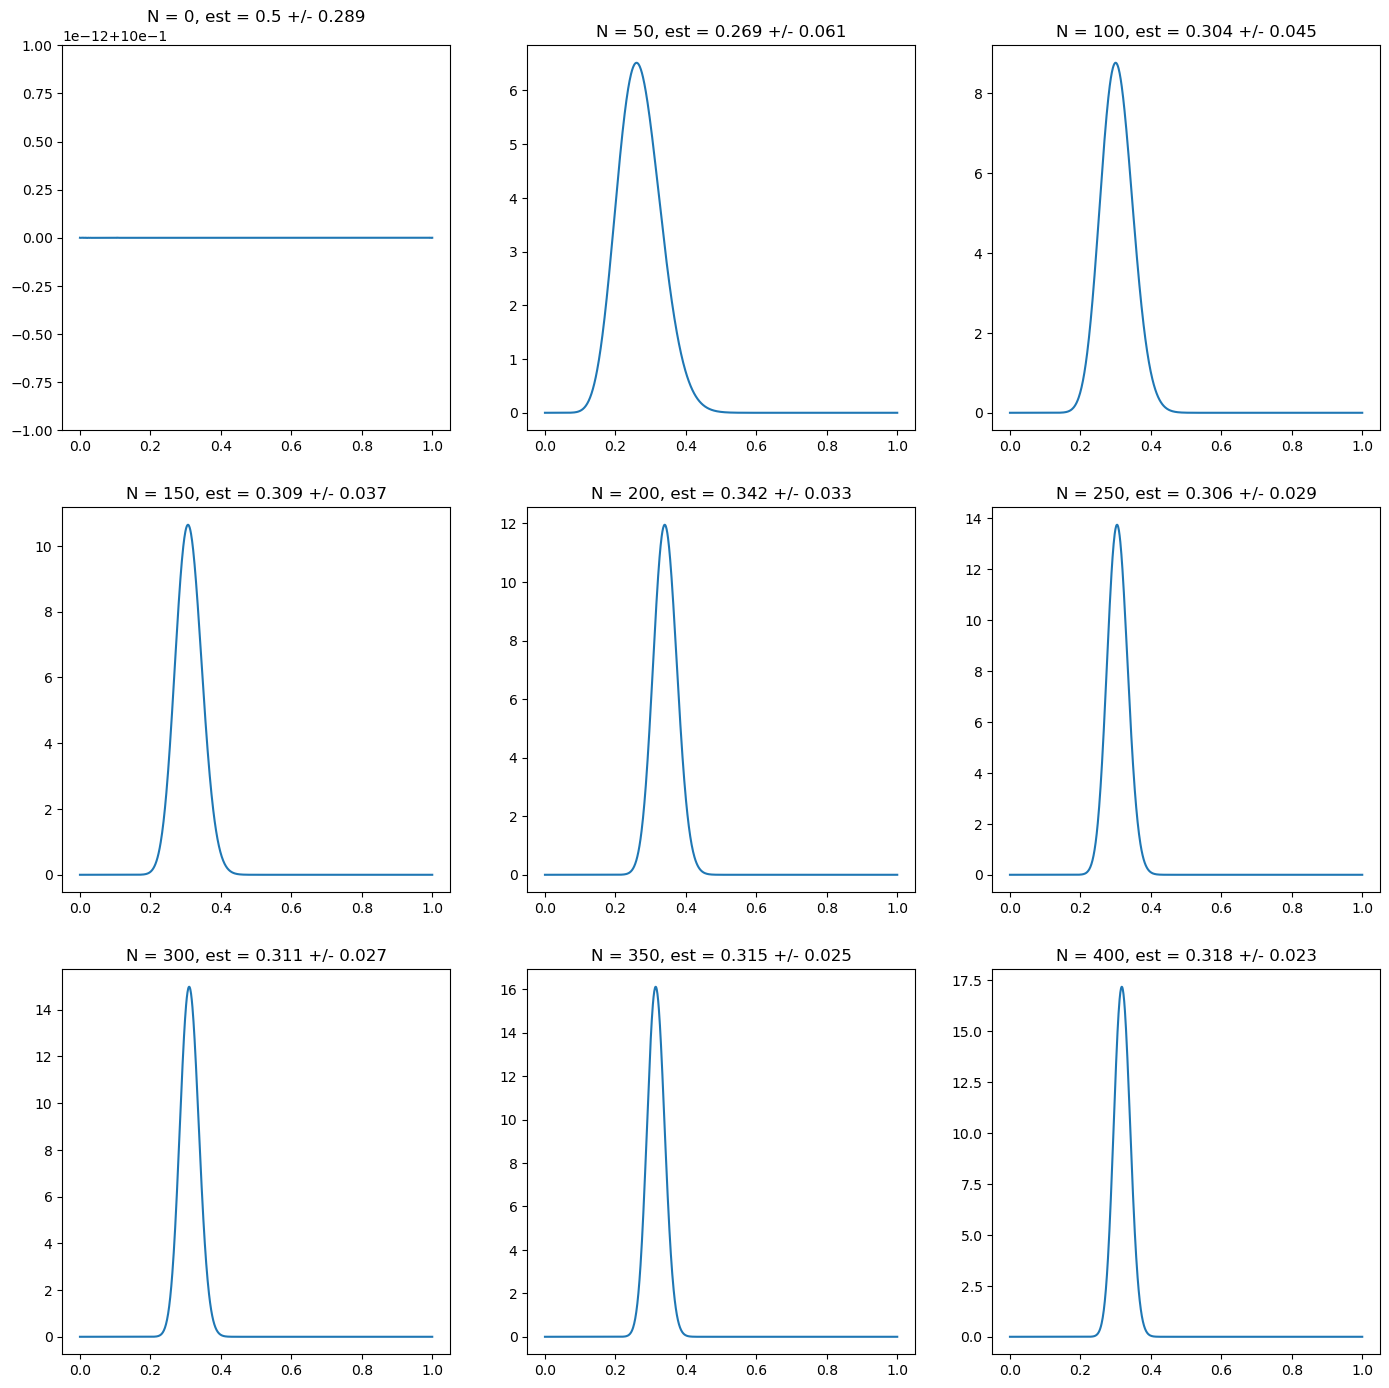

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: uniform prior
prior_alpha = 1
prior_beta = 1

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  p_grid = np.linspace(0, 1, 1000)
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

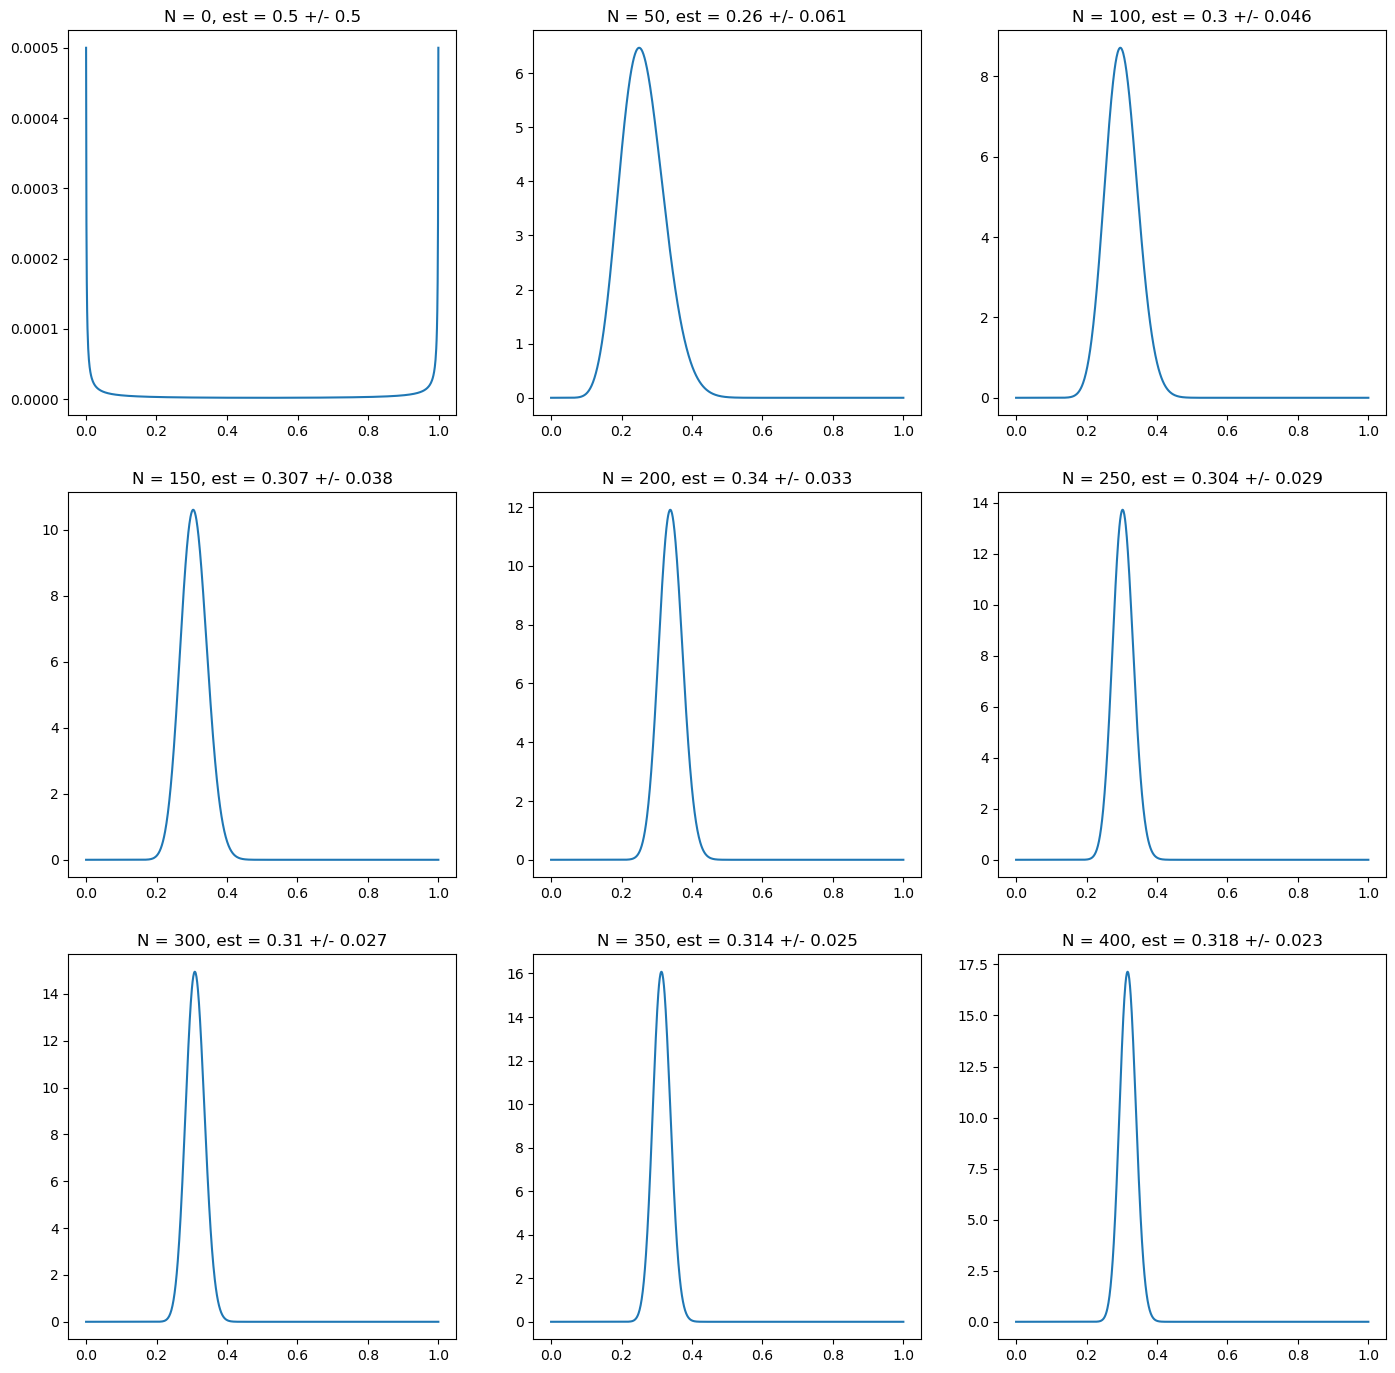

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: non - informative prior (approximation)
prior_alpha = 0.000001
prior_beta = 0.000001

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

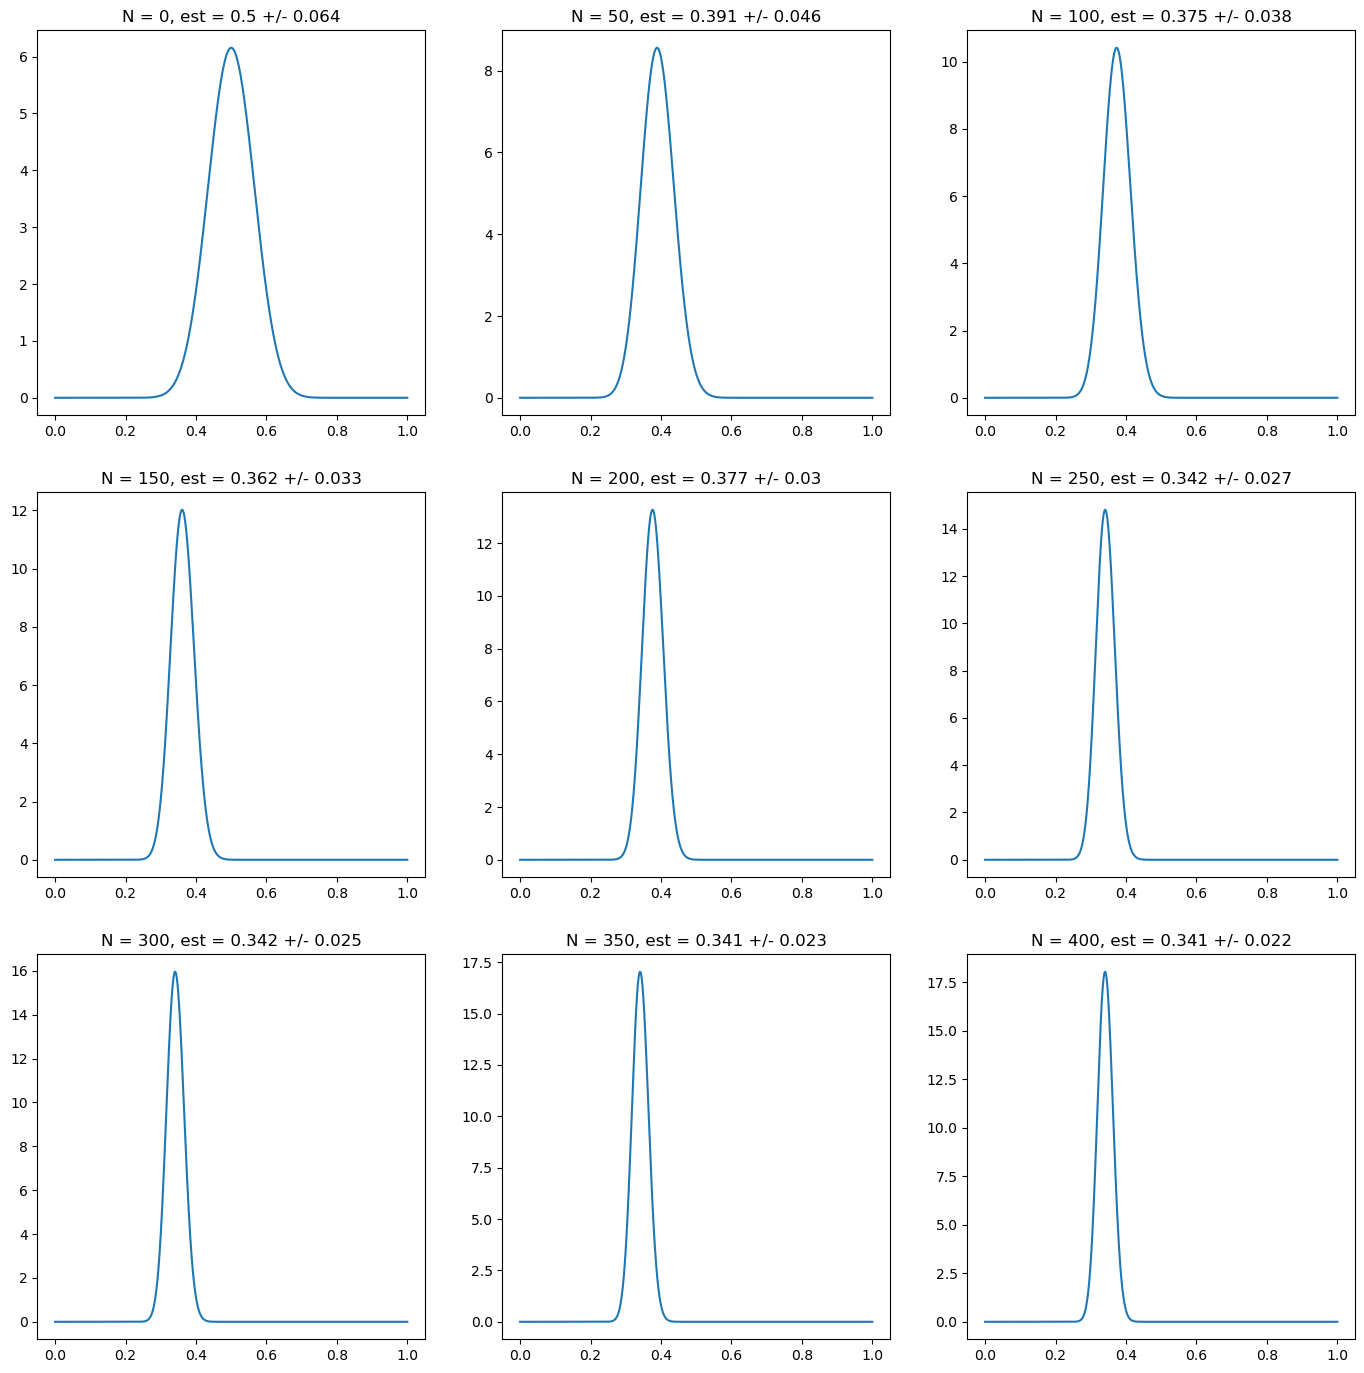

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: wrong confident prior
prior_alpha = 30
prior_beta = 30

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))

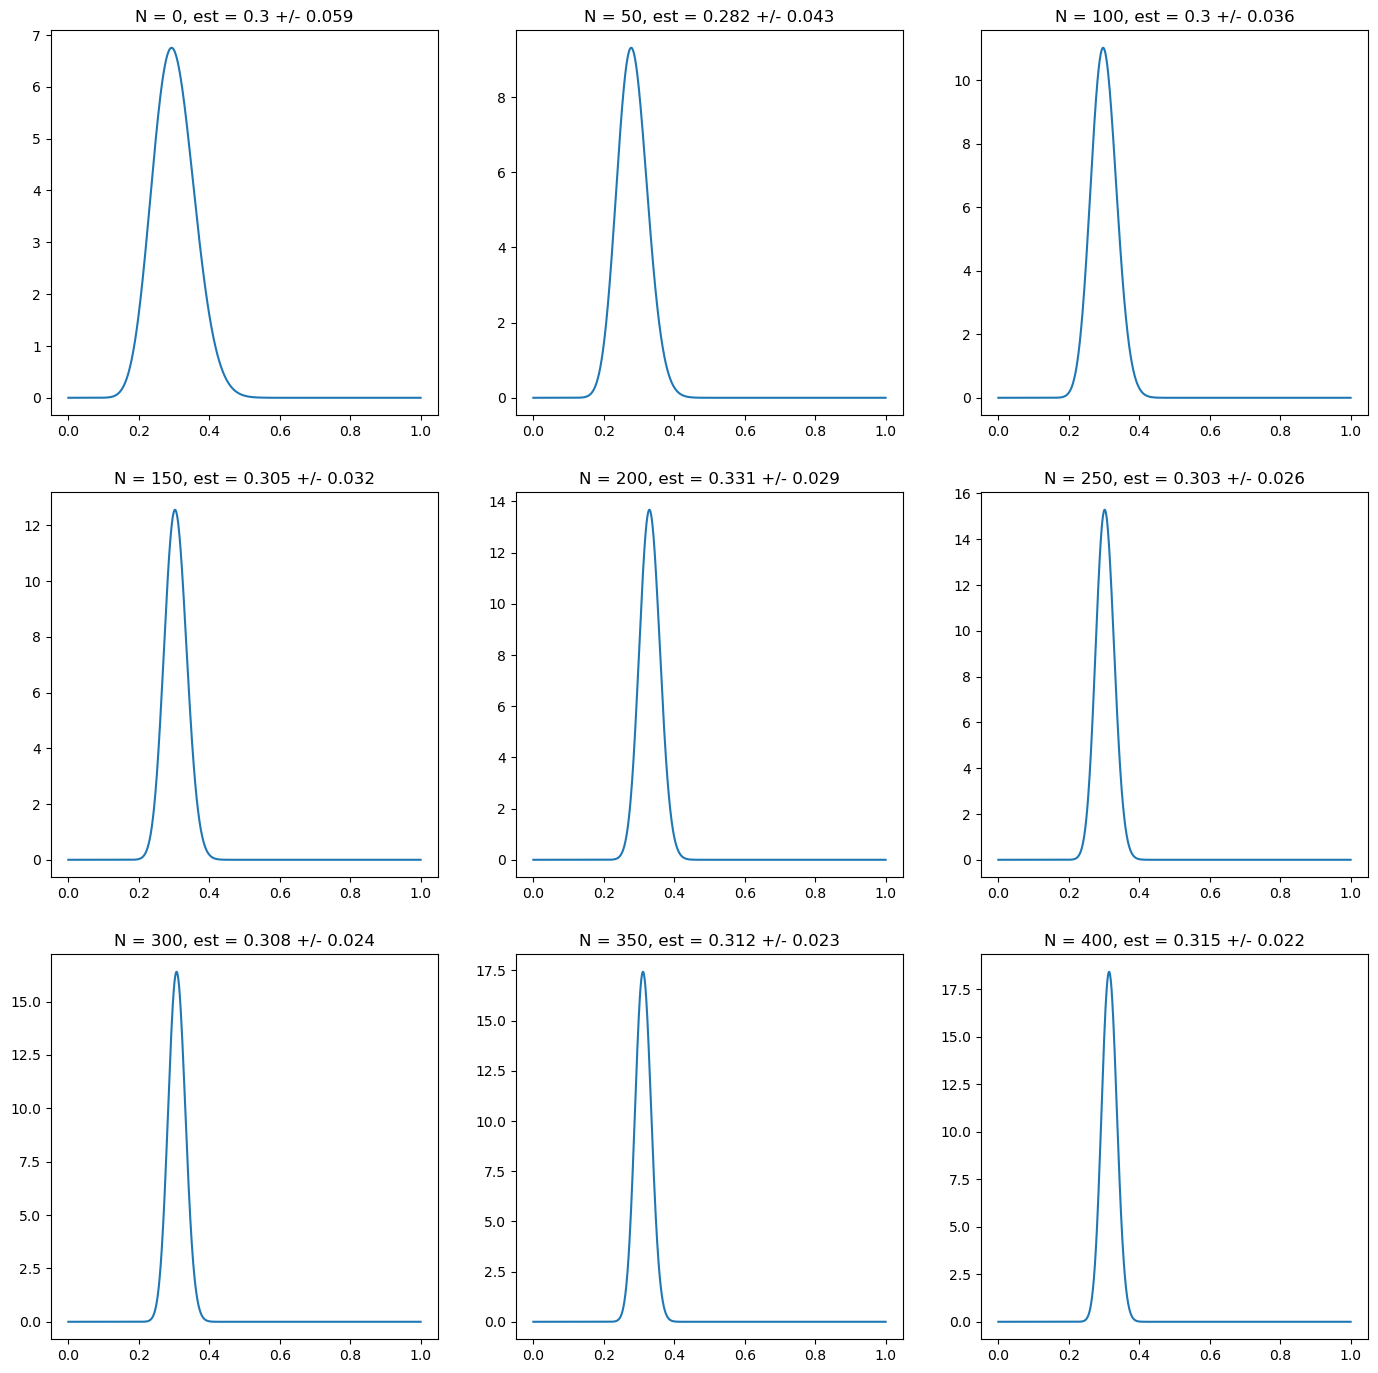

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# prior distribution: correct confident prior
prior_alpha = 18
prior_beta = 42

# Now we plot the distribution as we add more data points
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17,17))
N = np.linspace(0, len(r), 9)
for i in range(9):
  n = N[i]
  i_x = int(i/3)
  i_y = i % 3 
  r_trunc = r[:int(n)]  
  post_alpha = prior_alpha + np.sum(r_trunc)
  post_beta = prior_beta + len(r_trunc)- np.sum(r_trunc)
  mean = beta.mean(post_alpha, post_beta)
  std = beta.std(post_alpha, post_beta)
  ax[i_x][i_y].plot(p_grid, beta.pdf(p_grid, post_alpha, post_beta))
  ax[i_x][i_y].set_title("N = " + str(int(n))+ ", est = " + str(np.round(mean, 3)) + " +/- " + str(np.round(std, 3)))